<a href="https://colab.research.google.com/github/MAGPIEZ-CODE/MAGCalcium/blob/main/ExplorarAnalisisCalciov5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Import required libraries**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plot
import seaborn as sns
import numpy as np
from google.colab import files
from scipy import signal
from scipy.signal import detrend
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from scipy.signal import argrelextrema
from scipy.interpolate import CubicSpline
from scipy.signal import find_peaks

**2. Upload file**

In [33]:
uploaded = files.upload()

Saving ROI_Meanintensity_code.xlsx to ROI_Meanintensity_code.xlsx


**3. Read the file**

In [34]:
# Retrieve the name of the uploaded file
for filename in uploaded.keys():
    file_path = filename

# Read the Excel file
df = pd.read_excel(file_path)

# Exclude the first column (frame identifier)
df_sin_identificador = df.iloc[:, 1:]

# Identify the first empty column that separates ROIs and Background
columna_vacia = df_sin_identificador.columns[df_sin_identificador.isna().all()].tolist()

**4. Main Processing and Analysis Steps**

In [35]:
# Initialize DataFrame to store results
df_resultado = pd.DataFrame()

# Check if an empty column exists to separate ROI and Background
if columna_vacia:
    # Step 1: Get the index of the first empty column and identify ROI and Background columns
    idx_vacio = df_sin_identificador.columns.get_loc(columna_vacia[0])
    columnas_rois = df_sin_identificador.columns[:idx_vacio]
    columnas_fondo = df_sin_identificador.columns[idx_vacio + 1:]

    # Save the original ROIs in df_resultado at the beginning
    for i, col in enumerate(columnas_rois):
        df_resultado[f'Cell({i+1})'] = df_sin_identificador[col]

    # Insert a blank column before saving background values
    df_resultado[' '] = None

    # Step 2: Calculate the average background for each frame
    avg_fondo = df_sin_identificador[columnas_fondo].mean(axis=1)
    df_resultado['Avg_Fondo'] = avg_fondo

    # Insert a blank column before saving background-subtracted ROIs
    df_resultado['  '] = None

    # Step 3: Substract background from raw ROI
    roi_sin_fondo = pd.DataFrame({
        f'ROI_sF({i+1})': df_sin_identificador[col] - avg_fondo for i, col in enumerate(columnas_rois)
    })
    df_resultado = pd.concat([df_resultado, roi_sin_fondo], axis=1)

    # Insert a blank column
    df_resultado['   '] = None


    # Step 6: Calculate ΔF/F0 for each corrected ROI (F0 as the average of the first 4 frames)
    df_dff0_sin_fondo = pd.DataFrame()
    for i, col in enumerate(roi_sin_fondo.columns):
        roi_signal = roi_sin_fondo[col]
        F0 = roi_signal.iloc[:4].mean()
        df_dff0_sin_fondo[f'ROI_sF_DF/F0({i+1})'] = (roi_signal - F0) / F0
    df_resultado = pd.concat([df_resultado, df_dff0_sin_fondo], axis=1)

    # Insert a blank column
    df_resultado['      '] = None

    # Step 9: Activity based on ΔF/F0
    activity_sin_fondo = pd.DataFrame()
    for i, col in enumerate(df_dff0_sin_fondo.columns):
        dff0_signal = df_dff0_sin_fondo[col]
        std_f0 = dff0_signal.iloc[:6].std()
        activity_threshold = 3 * std_f0

        # Find peaks that meet the prominence condition
        peaks, properties = find_peaks(dff0_signal, prominence=(prominence_threshold, None))

        # Check which peaks also exceed the 3 standard deviation threshold
        peak_activity = np.zeros(len(dff0_signal), dtype=int)
        peak_activity[peaks] = (dff0_signal.iloc[peaks] > activity_threshold).astype(int)

        # Save the activity for the ROI in the DataFrame
        activity_sin_fondo[f'Activity_ROI_sF({i+1})'] = peak_activity

    df_resultado = pd.concat([df_resultado, activity_sin_fondo], axis=1)

    # Save results to an Excel file
    df_resultado.to_excel("output_calculated_steps_with_smoothed_envelope_detrended_area.xlsx", index=False)

    print("All calculations completed and saved to 'output_calculated_steps_with_smoothed_envelope_detrended_area.xlsx'.")

else:
    print("No empty column found to separate ROIs and background.")


All calculations completed and saved to 'output_calculated_steps_with_smoothed_envelope_detrended_area.xlsx'.


**5. Plot the original ROI data without any processing**

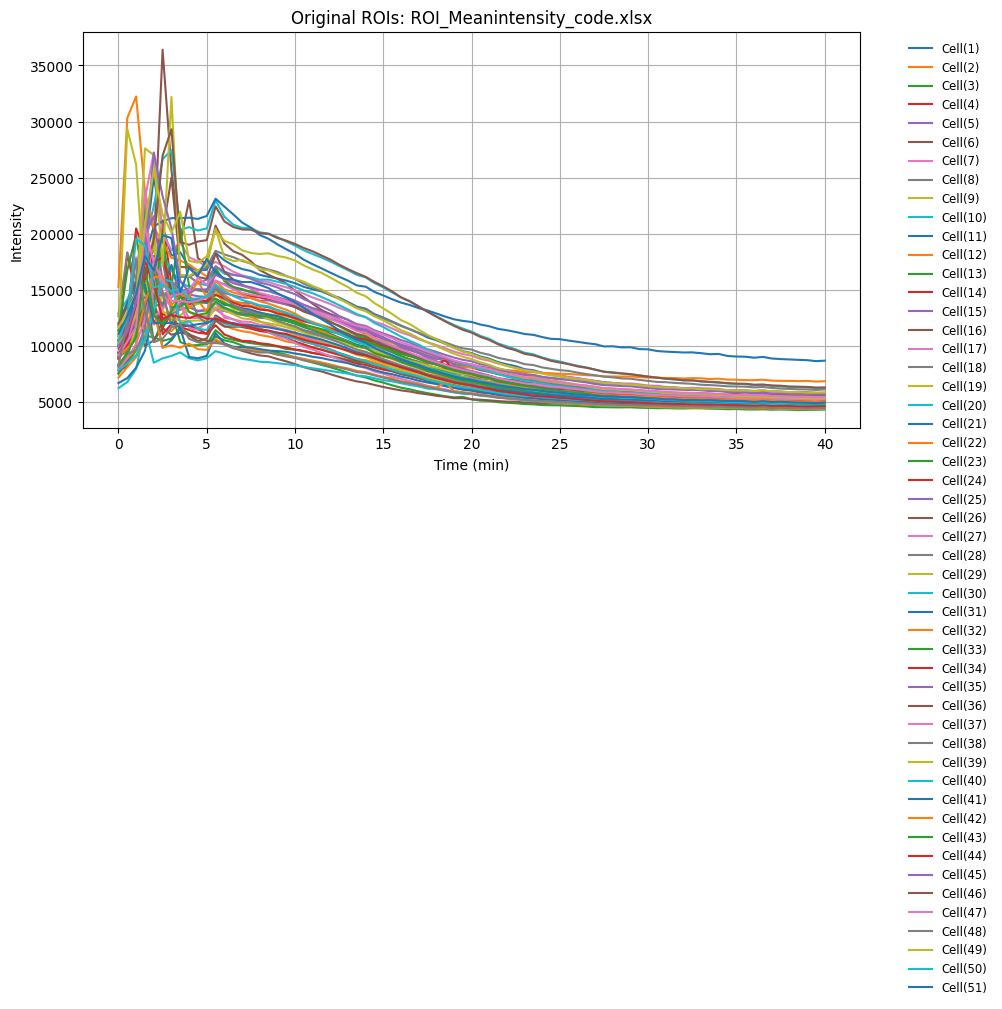

In [36]:
plt.figure(figsize=(12, 8))

# Plot each original ROI signal
for i, col in enumerate([col for col in df_resultado.columns if col.startswith("Cell(")]):
    plt.plot(df_resultado.index * 0.5, df_resultado[col], label=col)

plt.title(f"Original ROIs: {filename}")
plt.xlabel("Time (min)")
plt.ylabel("Intensity")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', frameon=False)
plt.grid(True)
plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.show()

**6. Plot the ROI data with background subtracted**

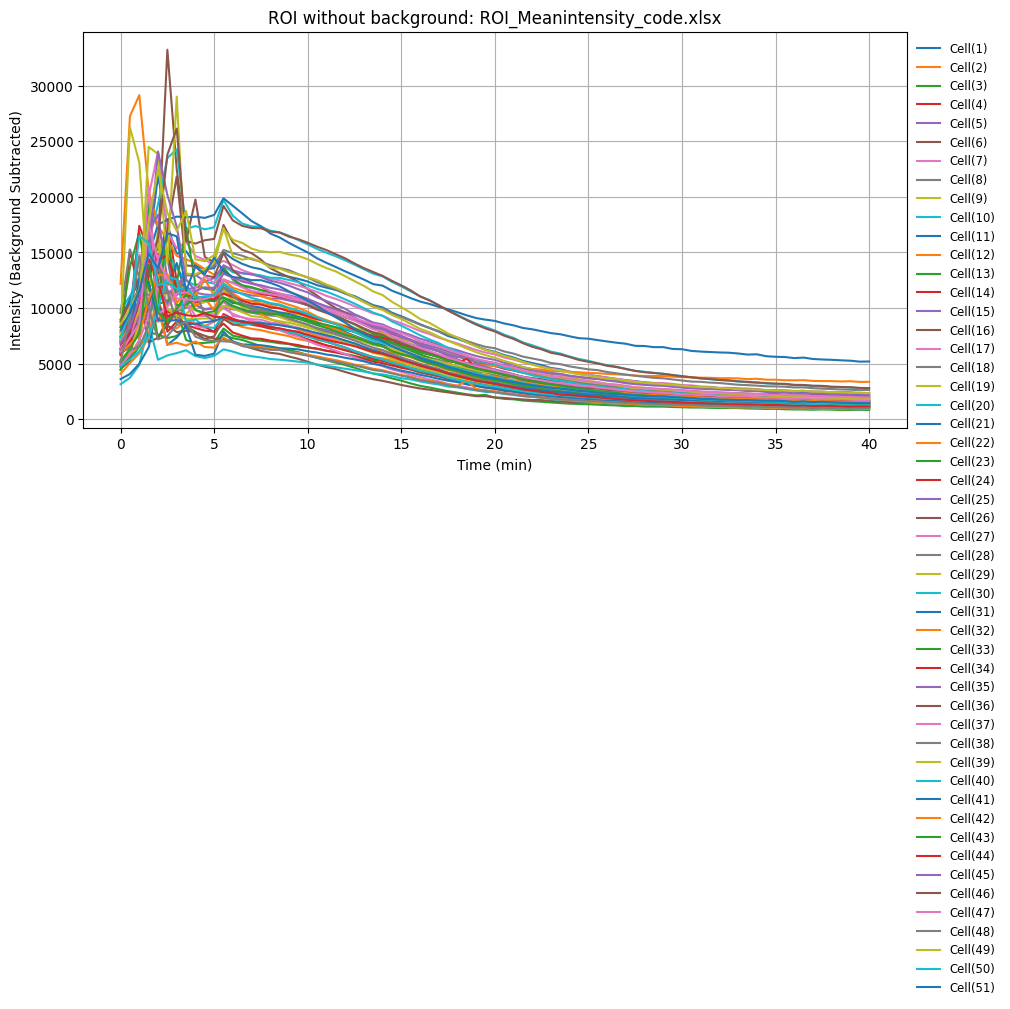

In [37]:
# Plot the ROI data with background subtracted
plt.figure(figsize=(12, 8))

for i in range(len(columnas_rois)):
    plt.plot(df_resultado.index*0.5, df_resultado[f'ROI_sF({i+1})'], label=f'Cell({i+1})')

plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize='small', frameon=False)
plt.title(f"ROI without background: {filename}")
plt.xlabel("Time (min)")
plt.ylabel("Intensity (Background Subtracted)")
plt.grid(True)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

**7. Plot of ΔF/F0 of Original ROI without background**

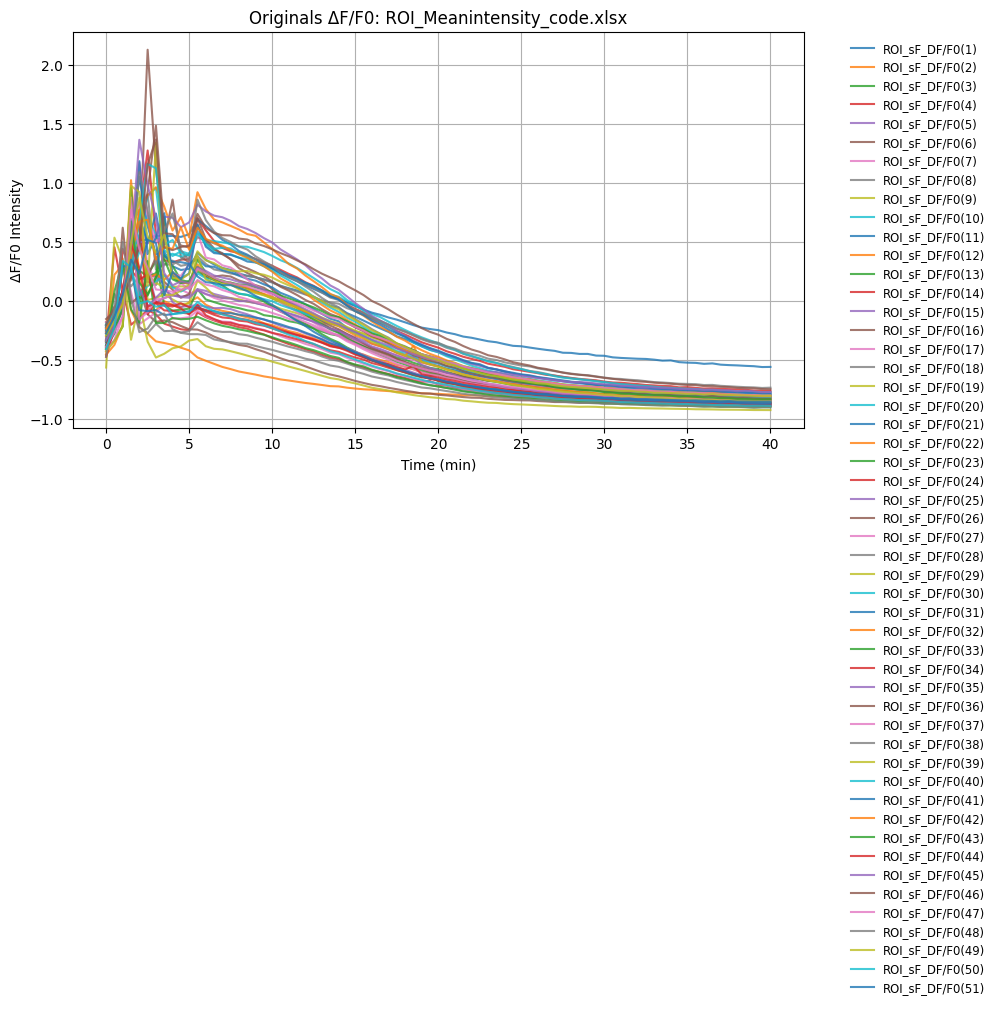

In [38]:
# Create a figure for plotting ΔF/F0 for each ROI
plt.figure(figsize=(12, 8))

for col in df_resultado.columns:
    if "ROI_sF_DF/F0" in col and "Detrended" not in col:
        plt.plot(df_resultado.index*0.5, df_resultado[col], label=col, alpha=0.8)

plt.title(f"Originals ΔF/F0: {filename}")
plt.xlabel("Time (min)")
plt.ylabel("ΔF/F0 Intensity")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', frameon=False)
plt.grid(True)
plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.show()

**8. Heatmap of DF/F0 of Original ROI without background**

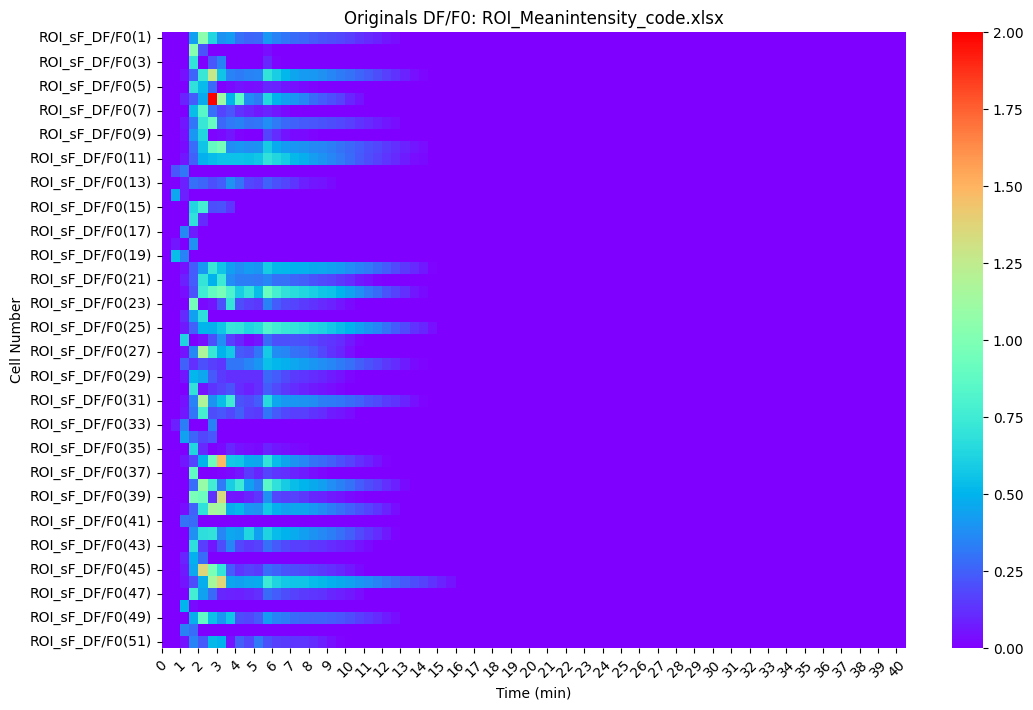

In [39]:
# Create a heatmap for plotting ΔF/F0 for each ROI
roi_sf_dff0_data = df_resultado[[col for col in df_resultado.columns if "ROI_sF_DF/F0" in col and "Detrended" not in col]]

plt.figure(figsize=(12, 8))
sns.heatmap(roi_sf_dff0_data.T, cmap="rainbow", cbar=True, annot=False, vmin=0, vmax=2)

plt.title(f"Originals DF/F0: {filename}")
plt.xlabel("Time (min)")
plt.ylabel("Cell Number")

num_frames = roi_sf_dff0_data.shape[0]
time_labels = np.arange(0, num_frames * 0.5, 0.5)
integer_time_labels = [int(time) for time in time_labels if time.is_integer()]

plt.xticks(ticks=np.arange(0, num_frames, 2), labels=integer_time_labels, rotation=45)

plt.show()

**9. Heatmap of Activity of Original ROI without background with find peak**

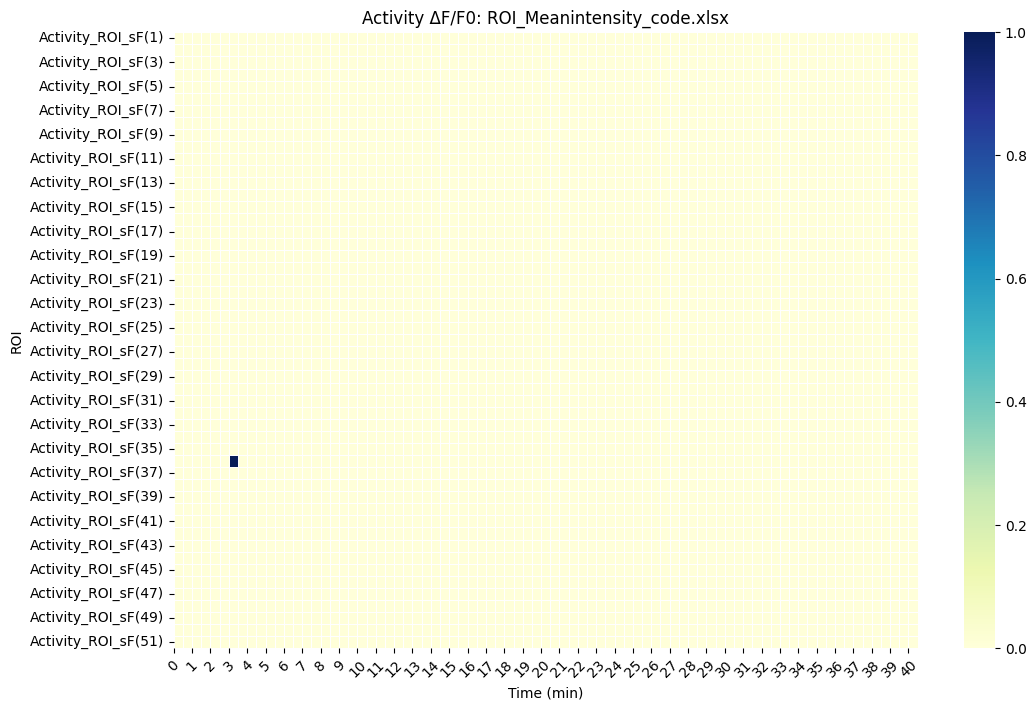

In [40]:
# Create a heatmap for plotting Activity for each ROI with find peak
activity_roi_sf_data = df_resultado[[col for col in df_resultado.columns if "Activity_ROI_sF" in col]]

plt.figure(figsize=(12, 8))
sns.heatmap(activity_roi_sf_data.T, cmap="YlGnBu", cbar=True, annot=False, linewidths=.5)

plt.title(f"Activity ΔF/F0: {filename}")
plt.xlabel("Time (min)")
plt.ylabel("ROI")

num_frames = roi_sf_dff0_data.shape[0]
time_labels = np.arange(0, num_frames * 0.5, 0.5)
integer_time_labels = [int(time) for time in time_labels if time.is_integer()]

plt.xticks(ticks=np.arange(0, num_frames, 2), labels=integer_time_labels, rotation=45)

plt.show()

**16. Save the generated file**

In [41]:
# Guardar el archivo modificado en Excel
df_resultado.to_excel('archivo_procesado.xlsx', index=False)
print("El archivo modificado ha sido guardado como 'archivo_procesado.xlsx'")

El archivo modificado ha sido guardado como 'archivo_procesado.xlsx'


In [42]:
# Descargar el archivo en tu computadora
files.download('archivo_procesado.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>